In [7]:
import torch
import torchvision
import os
from os.path import join as j_
from PIL import Image
import pandas as pd
import numpy as np

# loading all packages here to start
from uni import get_encoder
from uni.downstream.extract_patch_features import extract_patch_features_from_dataloader
from uni.downstream.eval_patch_features.linear_probe import eval_linear_probe
from uni.downstream.eval_patch_features.fewshot import eval_knn, eval_fewshot
from uni.downstream.eval_patch_features.protonet import ProtoNet, prototype_topk_vote
from uni.downstream.eval_patch_features.metrics import get_eval_metrics, print_metrics
from uni.downstream.utils import concat_images
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Downloading UNI 2 weights + Creating Model

The function `get_encoder` performs the commands above, downloading in the checkpoint in the `./assets/ckpts/` relative path of this GitHub repository.

In [2]:
from uni import get_encoder
model, transform = get_encoder(enc_name='uni2-h', device=device)

pytorch_model.bin:   0%|          | 0.00/2.73G [00:00<?, ?B/s]

### Download CRC-100K (No Norm)

You can download the CRC-100K ROI dataset at the following link: https://zenodo.org/records/1214456, which is a 9-class colorectal tissue classification task.
- Train (100K images, 11.7 GB): https://zenodo.org/records/1214456/files/NCT-CRC-HE-100K-NONORM.zip?download=1
- Test (7.180K images, 800.3 MB): https://zenodo.org/records/1214456/files/CRC-VAL-HE-7K.zip?download=1

Once you download these *.zip files, you can unzup them in your local directory (this example puts it in the `UNI/assets/data/CRC100K` relative path of the GitHub repository). The organization of these folders follows the the `torchvision.datasets.ImageFolder` structure, where the subfolders are labeled by the object class, and the images in each folder are of the same class.


In [8]:
dataroot = '../assets/data/CRC100K/'
assert os.path.isdir('../assets/data/CRC100K/NCT-CRC-HE-100K-NONORM')
assert os.path.isdir('../assets/data/CRC100K/CRC-VAL-HE-7K')

### ROI Feature Extraction

In [5]:
import time
from uni.downstream.extract_patch_features import extract_patch_features_from_dataloader

# get path to example data
start = time.time()
dataroot = '../assets/data/CRC100K/'

# create some image folder datasets for train/test and their data laoders
train_dataset = torchvision.datasets.ImageFolder(j_(dataroot, 'NCT-CRC-HE-100K-NONORM'), transform=transform)
test_dataset = torchvision.datasets.ImageFolder(j_(dataroot, 'CRC-VAL-HE-7K'), transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=False, num_workers=16)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=16)

# extract patch features from the train and test datasets (returns dictionary of embeddings and labels)
train_features = extract_patch_features_from_dataloader(model, train_dataloader)
test_features = extract_patch_features_from_dataloader(model, test_dataloader)

# convert these to torch
train_feats = torch.Tensor(train_features['embeddings'])
train_labels = torch.Tensor(train_features['labels']).type(torch.long)
test_feats = torch.Tensor(test_features['embeddings'])
test_labels = torch.Tensor(test_features['labels']).type(torch.long)
elapsed = time.time() - start
print(f'Took {elapsed:.03f} seconds')

100%|██████████| 29/29 [02:52<00:00,  5.94s/it]

Took 2493.643 seconds


### ROI Linear Probe Evaluation.

In [9]:
from uni.downstream.eval_patch_features.linear_probe import eval_linear_probe

linprobe_eval_metrics, linprobe_dump = eval_linear_probe(
    train_feats = train_feats,
    train_labels = train_labels,
    valid_feats = None ,
    valid_labels = None,
    test_feats = test_feats,
    test_labels = test_labels,
    max_iter = 1000,
    verbose= True,
)

print_metrics(linprobe_eval_metrics)

Linear Probe Evaluation: Train shape torch.Size([100000, 1536])
Linear Probe Evaluation: Test shape torch.Size([7180, 1536])
Linear Probe Evaluation (Train Time): Best cost = 138.240
Linear Probe Evaluation (Train Time): Using only train set for evaluation. Train Shape:  torch.Size([100000, 1536])
(Before Training) Loss: 2.197
(After Training) Loss: 0.030
Linear Probe Evaluation (Test Time): Test Shape torch.Size([7180, 1536])
Linear Probe Evaluation: Time taken 0.85
Test lin_acc: 0.969
Test lin_bacc: 0.957
Test lin_kappa: 0.988
Test lin_weighted_f1: 0.969
Test lin_auroc: 0.989


### ROI KNN and ProtoNet evaluation.

In [10]:
from uni.downstream.eval_patch_features.fewshot import eval_knn

knn_eval_metrics, knn_dump, proto_eval_metrics, proto_dump = eval_knn(
    train_feats = train_feats,
    train_labels = train_labels,
    test_feats = test_feats,
    test_labels = test_labels,
    center_feats = True,
    normalize_feats = True,
    n_neighbors = 20
)

print_metrics(knn_eval_metrics)
print_metrics(proto_eval_metrics)

Test knn20_acc: 0.969
Test knn20_bacc: 0.957
Test knn20_kappa: 0.981
Test knn20_weighted_f1: 0.969
Test proto_acc: 0.884
Test proto_bacc: 0.854
Test proto_kappa: 0.910
Test proto_weighted_f1: 0.876


### ROI Few-Shot Evaluation (based on ProtoNet)

In [11]:
from uni.downstream.eval_patch_features.fewshot import eval_fewshot

fewshot_episodes, fewshot_dump = eval_fewshot(
    train_feats = train_feats,
    train_labels = train_labels,
    test_feats = test_feats,
    test_labels = test_labels,
    n_iter = 100, # draw 500 few-shot episodes
    n_way = 9, # use all class examples
    n_shot = 16, # 4 examples per class (as we don't have that many)
    n_query = test_feats.shape[0], # evaluate on all test samples
    center_feats = True,
    normalize_feats = True,
    average_feats = True,
)

# how well we did picking 4 random examples per class
display(fewshot_episodes)

# summary
display(fewshot_dump)

100%|██████████| 100/100 [00:08<00:00, 11.54it/s]


,Kw16s_acc,Kw16s_bacc,Kw16s_kappa,Kw16s_weighted_f1
0,0.892340,0.866424,0.916397,0.891997
1,0.895822,0.866078,0.919425,0.893423
2,0.875905,0.848367,0.905563,0.870917
3,0.850696,0.819705,0.844237,0.847399
4,0.916574,0.895749,0.941318,0.922570
...,...,...,...,...
95,0.859889,0.831771,0.891898,0.853901
96,0.878412,0.847437,0.906158,0.867168
97,0.920056,0.895679,0.941247,0.923502
98,0.889694,0.860188,0.916960,0.885328


{'Kw16s_acc_avg': 0.8831309192200557,
 'Kw16s_bacc_avg': 0.8531128621027004,
 'Kw16s_kappa_avg': 0.9054352369279891,
 'Kw16s_weighted_f1_avg': 0.8770990479261518,
 'Kw16s_acc_std': 0.021386737136775854,
 'Kw16s_bacc_std': 0.02551466757902038,
 'Kw16s_kappa_std': 0.028371740644344983,
 'Kw16s_weighted_f1_std': 0.026225312838762376}

### A Closer Look at ProtoNet

You can use ProtoNet in a sklearn-like API as well for fitting and predicting models.

In [12]:
from uni.downstream.eval_patch_features.protonet import ProtoNet

# fitting the model
proto_clf = ProtoNet(metric='L2', center_feats=True, normalize_feats=True)
proto_clf.fit(train_feats, train_labels)
print('What our prototypes look like', proto_clf.prototype_embeddings.shape)

# evaluating the model
test_pred = proto_clf.predict(test_feats)
get_eval_metrics(test_labels, test_pred, get_report=False)

Num features averaged per class prototype:
	Class 0: 10407
	Class 1: 10566
	Class 2: 11512
	Class 3: 11557
	Class 4: 8896
	Class 5: 13536
	Class 6: 8763
	Class 7: 10446
	Class 8: 14317
Applying centering...
Applying normalization...
What our prototypes look like torch.Size([9, 1536])


{'acc': 0.8838440111420612,
 'bacc': 0.8539159622960268,
 'kappa': 0.9101360684446935,
 'weighted_f1': 0.8759136573096276}

Using `proto_clf._get_topk_queries_inds`, we use the test samples as the query set, and get the top-k queries to each prototype, effectively doing ROI retrieval.

label2idx correspondenes {'ADI': 0, 'BACK': 1, 'DEB': 2, 'LYM': 3, 'MUC': 4, 'MUS': 5, 'NORM': 6, 'STR': 7, 'TUM': 8}
Top-k ADIPOSE-like test samples to ADIPOSE prototype


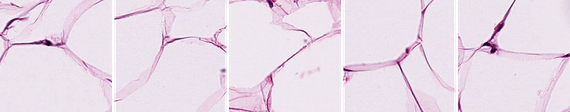

Top-k LYMPHOCYTE-like test samples to LYMPHOCYTE prototype


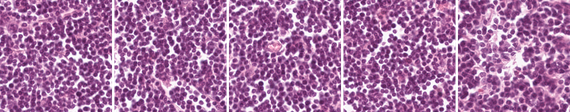

Top-k MUCOSA-like test samples to MUCOSA prototype


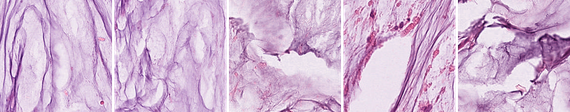

Top-k MUSCLE-like test samples to MUSCLE prototype


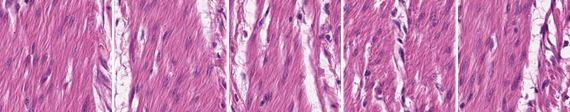

Top-k NORMAL-like test samples to NORMAL prototype


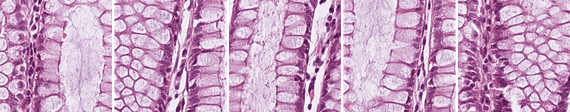

Top-k STROMA-like test samples to STROMA prototype


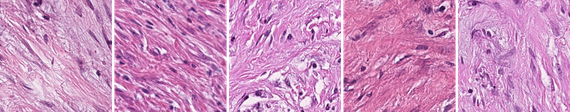

Top-k TUMOR-like test samples to TUMOR prototype


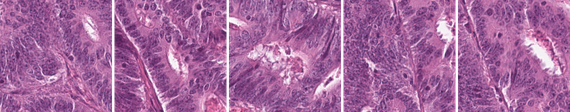

In [13]:
dist, topk_inds = proto_clf._get_topk_queries_inds(test_feats, topk=5)
print('label2idx correspondenes', test_dataset.class_to_idx)
test_imgs_df = pd.DataFrame(test_dataset.imgs, columns=['path', 'label'])

print('Top-k ADIPOSE-like test samples to ADIPOSE prototype')
adi_topk_inds = topk_inds[0]
adi_topk_imgs = concat_images([Image.open(img_fpath) for img_fpath in test_imgs_df['path'][adi_topk_inds]], scale=0.5, gap=5)
display(adi_topk_imgs)

print('Top-k LYMPHOCYTE-like test samples to LYMPHOCYTE prototype')
lym_topk_inds = topk_inds[3]
lym_topk_imgs = concat_images([Image.open(img_fpath) for img_fpath in test_imgs_df['path'][lym_topk_inds]], scale=0.5, gap=5)
display(lym_topk_imgs)

print('Top-k MUCOSA-like test samples to MUCOSA prototype')
muc_topk_inds = topk_inds[4]
muc_topk_imgs = concat_images([Image.open(img_fpath) for img_fpath in test_imgs_df['path'][muc_topk_inds]], scale=0.5, gap=5)
display(muc_topk_imgs)

print('Top-k MUSCLE-like test samples to MUSCLE prototype')
mus_topk_inds = topk_inds[5]
mus_topk_imgs = concat_images([Image.open(img_fpath) for img_fpath in test_imgs_df['path'][mus_topk_inds]], scale=0.5, gap=5)
display(mus_topk_imgs)

print('Top-k NORMAL-like test samples to NORMAL prototype')
norm_topk_inds = topk_inds[6]
norm_topk_imgs = concat_images([Image.open(img_fpath) for img_fpath in test_imgs_df['path'][norm_topk_inds]], scale=0.5, gap=5)
display(norm_topk_imgs)

print('Top-k STROMA-like test samples to STROMA prototype')
str_topk_inds = topk_inds[7]
str_topk_imgs = concat_images([Image.open(img_fpath) for img_fpath in test_imgs_df['path'][str_topk_inds]], scale=0.5, gap=5)
display(str_topk_imgs)

print('Top-k TUMOR-like test samples to TUMOR prototype')
tum_topk_inds = topk_inds[8]
tum_topk_imgs = concat_images([Image.open(img_fpath) for img_fpath in test_imgs_df['path'][tum_topk_inds]], scale=0.5, gap=5)
display(tum_topk_imgs)


Using `proto_clf._get_topk_prototypes_inds`, we can instead use the prototypes as the query set, and get the top-k queries to each test sample. With k set to # of prototypes / labels, we are essentially doing ROI classification (assigning label of the nearest prototype to the test sample).

In [14]:
dist, topk_inds = proto_clf._get_topk_prototypes_inds(test_feats, topk=9)
print("The top-9 closest prototypes to each test sample, with closer prototypes first (left hand side)")
display(topk_inds)

pred_test = topk_inds[:, 0]
get_eval_metrics(test_labels, test_pred, get_report=False)

The top-9 closest prototypes to each test sample, with closer prototypes first (left hand side)


array([[0, 7, 1, ..., 3, 6, 4],
       [0, 7, 1, ..., 4, 3, 6],
       [0, 7, 5, ..., 6, 4, 3],
       ...,
       [8, 7, 1, ..., 4, 6, 3],
       [8, 6, 7, ..., 0, 3, 4],
       [8, 7, 2, ..., 4, 0, 3]])

{'acc': 0.8838440111420612,
 'bacc': 0.8539159622960268,
 'kappa': 0.9101360684446935,
 'weighted_f1': 0.8759136573096276}